# Volume Inversion Using Feedforward Neural Network

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import timedelta

### Initialize
Import the neural network, and the training data from a separate file.

For the data generation for the feedforward network use the file 'vol_inv_data.py' and for the operator recurrent network the file 'for_opnet_vol_inv_data.py'.

In [5]:
#import simple_nn
import opnet
import simple_nn

from vol_inv_data import generate_data, save_data, load_data
PATH = './volume_inversion_test.pth'
#'./volume_inversion_400epochs_4982nodes_lr1e1_1.pth'   # define the path used to save trained parameters

from for_opnet_vol_inv_data import generate_data_op, save_data_op, load_data_op
PATH_OP = './volume_inversion_opnet_test.pth'
#'./volume_inversion_400epochs_GC_1_lr1e2_3.pth'

In [3]:
# Define the paths 
# To find best option to deal with the exploding error of opnet
PATH_GC ='./opnet_vol_inv_GC_1_relu_true_10_layers_lr1e2.pth' # gradient clipping
#'./opnet_vol_inv_GC_2_relu_true_10_layers_lr1e2.pth'
#'./opnet_vol_inv_GC_2_relu_true_10_layers_lr1e1.pth'
#'./opnet_vol_inv_GC_1_relu_true_10_layers_lr1e1.pth'
#'./opnet_vol_inv_GC_01_relu_true_10_layers_lr1e1.pth'
# './opnet_vol_inv_GC_001_relu_true_10_layers_lr1e1.pth'
#'./opnet_vol_inv_GC_001_relu_true_10_layers.pth' 
#'./opnet_vol_inv_GC_0_1_relu_true_10_layers.pth'
# './opnet_vol_inv_GC_1_relu_true_10_layers.pth'

PATH_REG = './opnet_volume_inversion_REG_1e_min7_relu_true.pth' # L2-regularization

Define the optimizer, model and loss function.

Intialize parameters for the feedforward network.

In [7]:
dim = 126 # the size of Lambda_h
num_nodes = 4982 # the number of nodes in the 1st layer output/ 2nd layer input
model = simple_nn.NeuralNetwork(dim, num_nodes)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

Initialize parameters for the operator network.

In [8]:
dim = 126 # this needs be the size of Lambda_h
num_layers = 10
model_op = opnet.OperatorNet(dim, num_layers, scalar_output=True, useReLU = True)
loss_fn_op = torch.nn.MSELoss()
optimizer_op = torch.optim.SGD(model_op.parameters(), lr=1e-2)
#optimizer_op = torch.optim.SGD(model_op.parameters(),lr=1e-4, weight_decay = 1e-10) # Optimizer with L2-penalty

### Generate the data

In [5]:
# Generate data separately for both the feedforward network and operator recurrent network

#save_data(*generate_data(6000), "volume_inversion_train_data2.npz")
#save_data(*generate_data(1000), "volume_inversion_test_data2.npz")

#save_data_op(*generate_data_op(6000), "for_opnet_volume_inversion_train_data2.npz")
#save_data_op(*generate_data_op(1000), "for_opnet_volume_inversion_test_data2.npz")

### Train the data

In [9]:
# Load the training data
train_loader = torch.utils.data.DataLoader(
    load_data("volume_inversion_train_data2.npz"), 
    batch_size=64)

# This for operator network
train_loader_op = torch.utils.data.DataLoader(
    load_data_op("for_opnet_volume_inversion_train_data2.npz"), 
    batch_size=64)

In [6]:
#From: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

# check the amount of parameters
def count_parameters(model):
   
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)
count_parameters(model_op)

Total Trainable Params: 637697
Total Trainable Params: 637686


637686

The feedforward neural network

In [10]:
losses = []
start = time.time()

# Loop over the training data
for epoch in range(5): 
    print(f"Epoch {epoch+1}\n-------------------------------")
    running_loss = 0.0
    for batch, (X, y) in enumerate(train_loader):
    # Compute prediction error
        pred = model(X)
        pred2 = pred.squeeze(1)
        loss = loss_fn(pred2, y)
        
        running_loss += loss.item() * X.size(0)
       
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        # Print statistics
        if batch % 100 == 0:
            n, N = (batch + 1) * len(X), len(train_loader.dataset)
            print(f"loss: {loss.item():>7f}  [{n:>5d}/{N:>5d}]")

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f" epoch_loss: {epoch_loss}")
    losses.append(epoch_loss)
    
torch.save(model.state_dict(), PATH)

end = time.time()
total_time = timedelta(seconds = end-start);
print(f'Total time: {total_time}')

Epoch 1
-------------------------------
loss: 0.382516  [   64/ 6000]
 epoch_loss: 1.205005401990066
Epoch 2
-------------------------------
loss: 0.004057  [   64/ 6000]
 epoch_loss: 0.002926739138861497
Epoch 3
-------------------------------
loss: 0.002318  [   64/ 6000]
 epoch_loss: 0.0020645225482682386
Epoch 4
-------------------------------
loss: 0.001665  [   64/ 6000]
 epoch_loss: 0.0016771368604774277
Epoch 5
-------------------------------
loss: 0.001348  [   64/ 6000]
 epoch_loss: 0.0014431791647026937
Total time: 0:00:06.063421


In [6]:
# Save the epoch losses of one run for plotting
#path= './_volum_inv_epochlosses_ffn_model_comp_6000pcs_400epochs_4982nodes_lr1e1_set3.pth'
#torch.save(losses,path)

Plot epoch losses of a few different training times

In [13]:
# load the data
#a = torch.load('_volum_inv_epochlosses_ffn_model1_6000pcs_300epochs_set1.pth')
#b = torch.load('_volum_inv_epochlosses_ffn_model1_6000pcs_300epochs_set2.pth')
#c = torch.load('_volum_inv_epochlosses_ffn_model1_6000pcs_300epochs_set3.pth')

# plot epoch losses from multiple runs
#plt.semilogy(a, 'r')
#plt.semilogy(b, 'b')
#plt.semilogy(c, 'g')

#plt.xlabel('Epochs')
#plt.ylabel('Mean Squared Error')
#plt.xlim([0, 299])

#plt.legend(['Feedforward Network'])
#plt.title(f'Volume Inversion Traning Data Error')

# Save the plot
#plt.savefig('mse_per_epochs_ffn_volume_inv_300_epochs_multiple_training_sets_6000pcs_model1.jpg')

The operator recurrent network

In [14]:
losses_opnet = []
start = time.time()
# Loop over the training data
for epoch in range(5):
    print(f"Epoch {epoch+1}\n-------------------------------")
    running_loss_op = 0.0
    for batch, (X_o, y_o) in enumerate(train_loader_op):
    # Compute prediction error
    
        pred_op = model_op(X_o)   
        loss_op = loss_fn_op(pred_op, y_o)
             
        running_loss_op += loss_op.item() * X_o.size(0)
        
        # Backpropagation
        optimizer_op.zero_grad()
        loss_op.backward()
        
        # gradient clipping to prevent gradient explosion
        torch.nn.utils.clip_grad_norm_(model_op.parameters(), 1)
        
        optimizer_op.step()
        
        # Print statistics
        if batch % 100 == 0:
            n, N = (batch + 1) * len(X_o), len(train_loader_op.dataset)
            print(f"loss: {loss_op.item():>7f}  [{n:>5d}/{N:>5d}]")
    #print(f"loss:{loss_op.item() /= len(train_loader_op):>7f}")
    epoch_loss_op = running_loss_op / len(train_loader_op.dataset)
    print(f" epoch_loss: {epoch_loss_op}")
    losses_opnet.append(epoch_loss_op)
    
    
torch.save(model_op.state_dict(), PATH_OP)
end = time.time()
total_time = timedelta(seconds=end-start)
print(f'Total time: {total_time}')

Epoch 1
-------------------------------
loss: 2333718.500000  [   64/ 6000]
 epoch_loss: 70568.78519816081
Epoch 2
-------------------------------
loss: 4747.781738  [   64/ 6000]
 epoch_loss: 508.6336196867625
Epoch 3
-------------------------------
loss: 4.110128  [   64/ 6000]
 epoch_loss: 0.4278785620033741
Epoch 4
-------------------------------
loss: 0.099514  [   64/ 6000]
 epoch_loss: 0.029549583646158378
Epoch 5
-------------------------------
loss: 0.019805  [   64/ 6000]
 epoch_loss: 0.012892704340318839
Total time: 0:00:10.896881


In [6]:
# Save the epoch losses of one run for plotting
#path= './vol_inv_epochlosses_op_6000pcs_400epochs_clipped_grad_1_10_layers_lr1e2_set3.pth'
#torch.save(losses_opnet,path)

### Plot - comparison

Plot the epoch losses of both networks for comparison.

In [15]:
#a =  torch.load('_volum_inv_epochlosses_ffn_model_comp_6000pcs_400epochs_4982nodes_lr1e1_set1.pth')
#b =  torch.load('_volum_inv_epochlosses_ffn_model_comp_6000pcs_400epochs_4982nodes_lr1e1_set2.pth')
#c =  torch.load('_volum_inv_epochlosses_ffn_model_comp_6000pcs_400epochs_4982nodes_lr1e1_set3.pth')
#d =  torch.load('vol_inv_epochlosses_op_6000pcs_400epochs_clipped_grad_1_10_layers_lr1e2_set1.pth')
#e =  torch.load('vol_inv_epochlosses_op_6000pcs_400epochs_clipped_grad_1_10_layers_lr1e2_set2.pth')
#f =  torch.load('vol_inv_epochlosses_op_6000pcs_400epochs_clipped_grad_1_10_layers_lr1e2_set3.pth')

#plt.semilogy(a, 'r', label= 'Feedforward Network, lr = 1e-1')
#plt.semilogy(b, 'r')
#plt.semilogy(c, 'r')
#plt.semilogy(d, 'b', label = 'Operator Network, lr = 1e-2')
#plt.semilogy(e, 'b')
#plt.semilogy(f, 'b')
#plt.xlabel('Epochs')
#plt.ylabel('Mean Squared Error')
#plt.xlim([0, 399])

#plt.legend()
#plt.title(f'Comparison of Volume Inversion Training Data Error')

# Save the plot
#plt.savefig('mse_per_epochs_comparison_volume_inv_6000samples_opnet_10_layers_2.jpg')

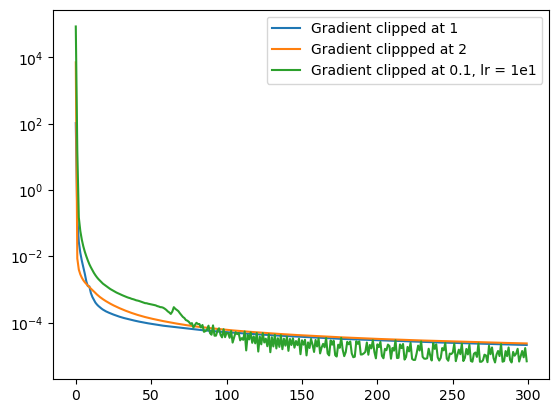

In [17]:
#Plot, gradient clipping with different values to choose best
gc2 = torch.load('./vol_inv_epochlosses_op_6000pcs_300epochs_clipped_grad_2_10_layers_lr1e2.pth')
gc1 = torch.load('./vol_inv_epochlosses_op_6000pcs_300epochs_clipped_grad_1_10_layers_lr1e2.pth')
gc01 = torch.load('./vol_inv_epochlosses_op_6000pcs_300epochs_clipped_grad_0_1_10_layers_lr1e1.pth')

plt.semilogy(gc1)
plt.semilogy(gc2)
plt.semilogy(gc01)
#plt.semilogy(losses_opnet)
plt.legend(['Gradient clipped at 1','Gradient clippped at 2', 'Gradient clipped at 0.1, lr = 1e1'])

### Test the data


If the data is already trained, load the trained parameters.

In [11]:
## Load trained variables
#PATH ='volume_inversion_net_3150nodes1.pth'
#PATH2 = 'volume_inversion_net_3150nodes2.pth'
#PATH3 = 'volume_inversion_net_3150nodes3.pth'

model.load_state_dict(torch.load(PATH))

model_op.load_state_dict(torch.load(PATH_OP))

<All keys matched successfully>

In [7]:
# Load the testing data

# For shallow network
test_loader = torch.utils.data.DataLoader(
    load_data("volume_inversion_test_data2.npz"),
    batch_size=64)

# For operator network
test_loader_op = torch.utils.data.DataLoader(
    load_data_op("for_opnet_volume_inversion_test_data2.npz"),
    batch_size=64)


Calculate samples for comparison

#### Feedforward Neural Network

Calculate a sample

In [8]:
dataiter = iter(test_loader)
X, y = dataiter.next()
with torch.no_grad():
    pred = model(X).squeeze(1)
print("True: ")
print(y[:2])
print("Prediction: ")
print(pred[:2])

True: 
tensor([0.8162, 0.7978])
Prediction: 
tensor([0.8173, 0.8004])


Calculate average error

In [8]:
num_batches = len(test_loader)
test_loss = 0
with torch.no_grad():
    for X, y in test_loader:
        pred = model(X)
        test_loss += loss_fn(pred.squeeze(1), y).item()
test_loss /= num_batches
print(f"Avg loss: {test_loss:>8f} \n")


Avg loss: 0.000011 



#### Operator Recurrent Neural Network

In [9]:
dataiter_op = iter(test_loader_op)
X_o, y_o = dataiter_op.next()
with torch.no_grad():
    pred_op = model_op(X_o)
   
print("True: ")
print(y_o[:2])
print("Prediction: ")
print(pred_op[:2])

True: 
tensor([0.4143, 0.3950])
Prediction: 
tensor([0.4146, 0.3967])


Calculate the average loss

In [8]:
num_batches = len(test_loader_op)
test_loss_op = 0
with torch.no_grad():
    for X_o, y_o in test_loader_op:
        pred_op = model_op(X_o)
        test_loss_op += loss_fn_op(pred_op,y_o).item() 
test_loss_op /= num_batches
print(f"Avg loss: {test_loss_op:>8f} \n")

Avg loss: 0.000021 

